(the tldr of all this)

**Pipeline:** 

Load data --> Data vizualization / EDA -->  NA imputation --> Feature Engineering --> Modelling

**Details:**

Data vizualization
- correlation of numeric variables with target
- scatter plots of the most correlated variables
- histogram of target variable

NA imputation 
- Two imputers were created
    - for numerical vars the imputing strategy was the mean
    - for categorical vars the most frequent value)

Feature Engineering 

- Prepare the target variable (take the log so that errors in predicting expensive houses and cheap houses will affect the result equally)
- One hot enconding for categorical vars

Modelling 

- Tested several models in default settings 
- From this, tuned some models
    - Lasso (with feature selection using RFECV)
    - Gradient Boosting Regressor (with feature selection using RFECV)
    - Random Forests
    - Ridge (with feature selection using RFECV)
- Experimented with Stacked Ensembles with the best tuned models
    - Using StackingRegressor
    - "Manual" Stacking with only the two best models *(best submission)*

Conclusion

The best model is a weighted prediction (70% from GBR and 30% from Ridge). GBR (especially with FS) works well in this case due to the relatively high number of features (even after FS, aprox 200). Moreover, it captures non-linear relationships between variables and the target which appears to be the case for some (from the scatter plots). 


In [12]:
# load packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import scipy as sp

# models

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

# helpers

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#### Load data

In [13]:
raw_data = pd.read_csv('train.csv')
val_data = pd.read_csv('test.csv')

print(raw_data.shape)
print(val_data.shape)

# check the data

print(raw_data.head(10))

(1460, 81)
(1459, 80)
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   
5   6          50       RL         85.0    14115   Pave   NaN      IR1   
6   7          20       RL         75.0    10084   Pave   NaN      Reg   
7   8          60       RL          NaN    10382   Pave   NaN      IR1   
8   9          50       RM         51.0     6120   Pave   NaN      Reg   
9  10         190       RL         50.0     7420   Pave   NaN      Reg   

  LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
0         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1         Lvl

In [14]:
# check NAs

nasdata = raw_data.isna().sum()
nasval = val_data.isna().sum()

#### Data vizualization

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

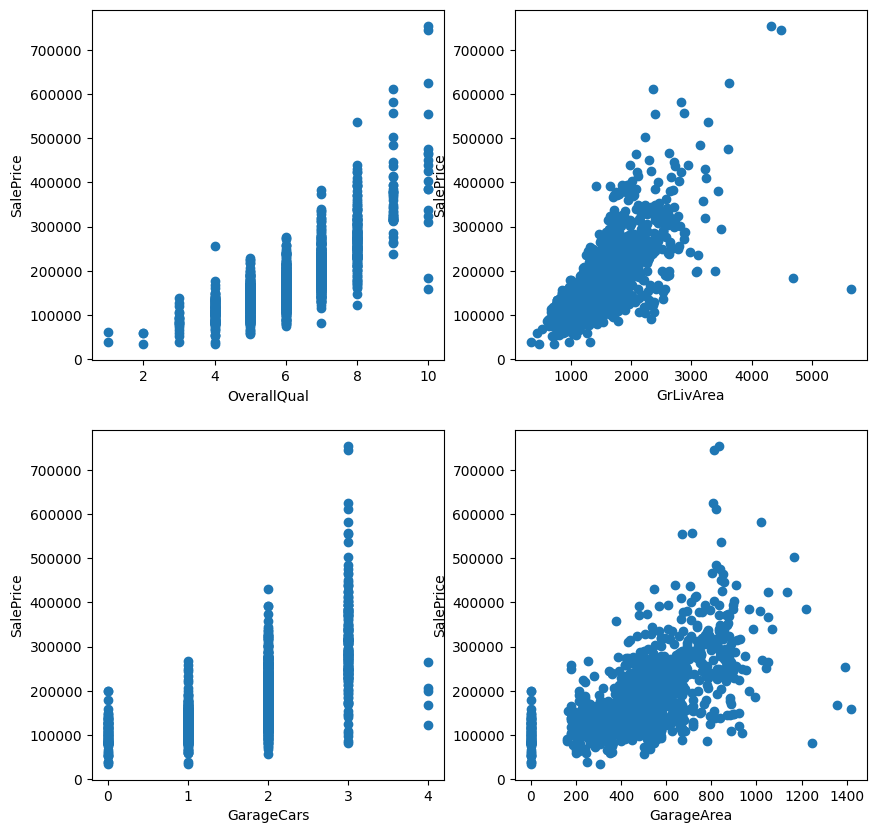

In [15]:
# correlation between sale price and the other numeric  variables

numeric_data = raw_data.select_dtypes(include=[np.number])
corr = numeric_data.corr()
print(corr['SalePrice'].sort_values(ascending=False))

# scatter plots of the most correlated variables in a subplot

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.scatter(raw_data['OverallQual'], raw_data['SalePrice'])
plt.xlabel('OverallQual')
plt.ylabel('SalePrice')
plt.subplot(2, 2, 2)
plt.scatter(raw_data['GrLivArea'], raw_data['SalePrice'])
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.subplot(2, 2, 3)
plt.scatter(raw_data['GarageCars'], raw_data['SalePrice'])
plt.xlabel('GarageCars')
plt.ylabel('SalePrice')
plt.subplot(2, 2, 4)
plt.scatter(raw_data['GarageArea'], raw_data['SalePrice'])
plt.xlabel('GarageArea')
plt.ylabel('SalePrice')
plt.show()



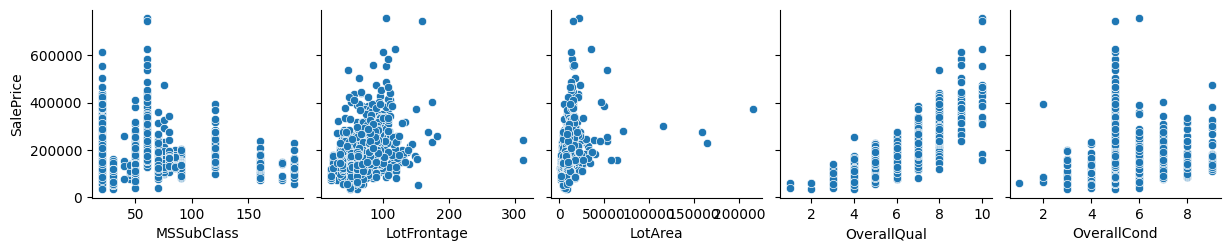

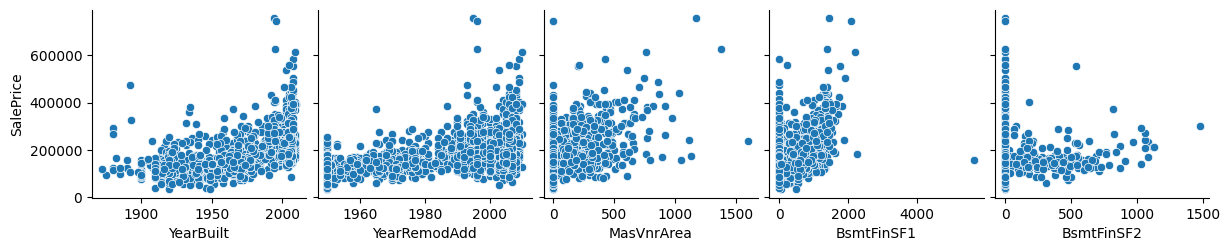

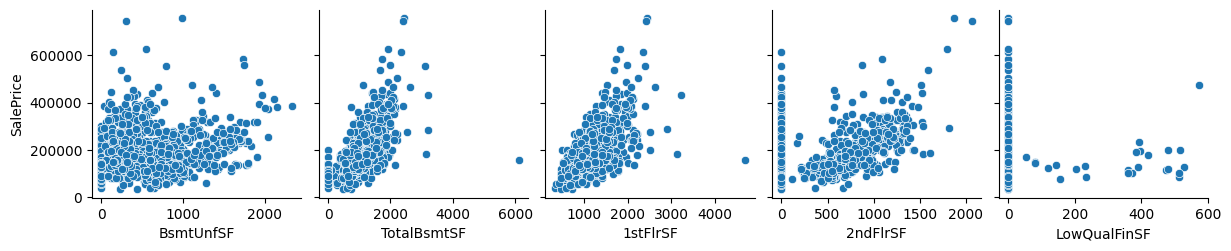

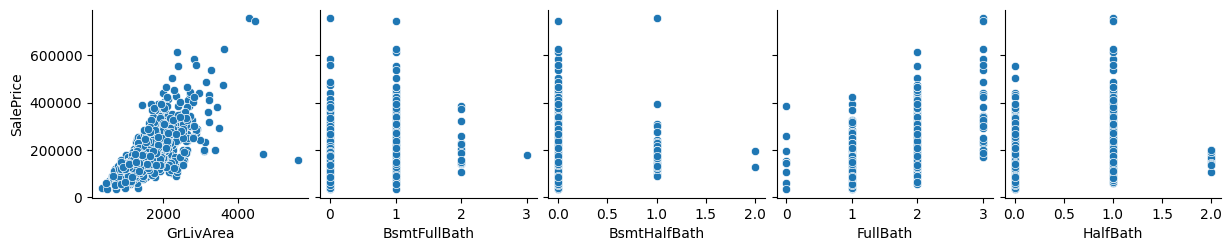

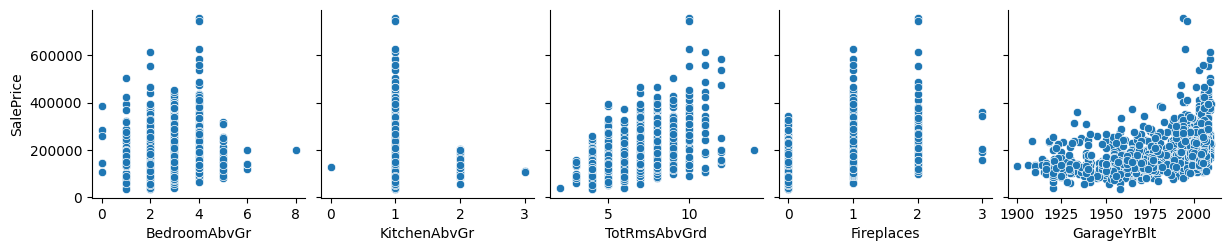

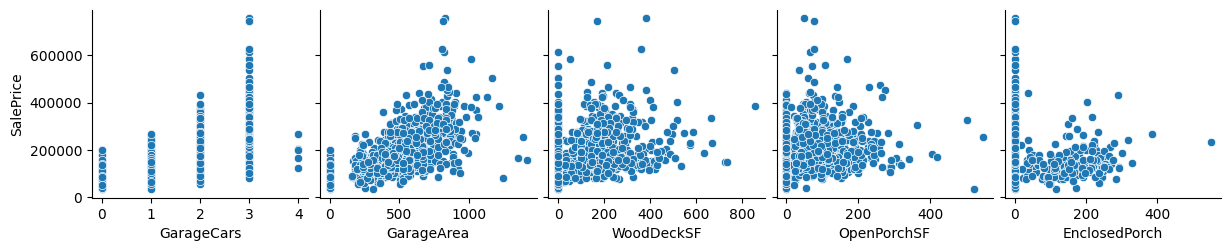

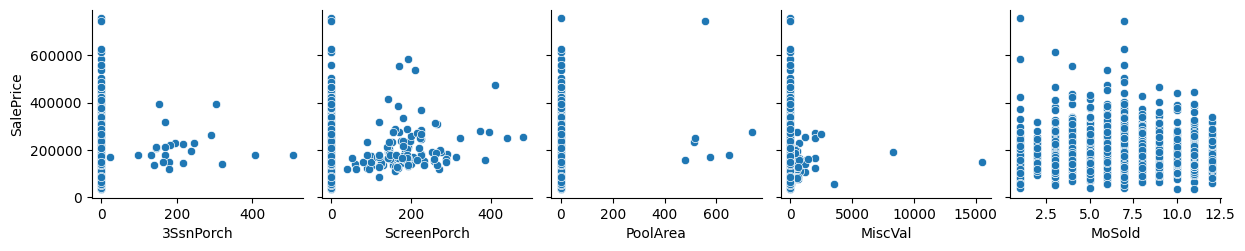

In [18]:
# scatter plots between sale price and all numeric vars except sale price

for i in range(1, len(numeric_data.columns)-5, 5):
    sns.pairplot(data=raw_data, y_vars=['SalePrice'], x_vars=numeric_data.columns[i:i+5])

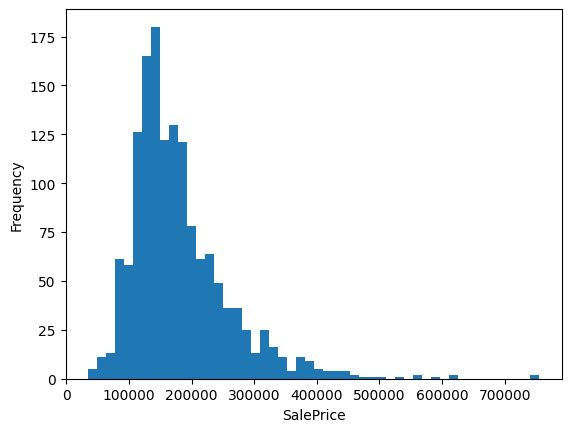

In [6]:
# histogram of sale price

plt.hist(raw_data['SalePrice'], bins=50)
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()

In [7]:
# deep copy

data = raw_data.copy()
val = val_data.copy()

cleaner = [data, val]

# deep copy2 (without NAs)

data2 = raw_data.copy()
val2 = val_data.copy()

cleaner2 = [data2, val2]


#### NA imputation

In [8]:
from sklearn.impute import SimpleImputer
imputer_num = SimpleImputer(strategy='mean')
imputer_cat = SimpleImputer(strategy='most_frequent')

# numerical cols

num_colsdata = data.select_dtypes(include=[np.number]).columns
num_colsval = val.select_dtypes(include=[np.number]).columns

# categorical cols

cat_cols = data.select_dtypes(include=[object]).columns

data2[num_colsdata] = imputer_num.fit_transform(data2[num_colsdata])
data2[cat_cols] = imputer_cat.fit_transform(data2[cat_cols])
val2[num_colsval] = imputer_num.fit_transform(val2[num_colsval])
val2[cat_cols] = imputer_cat.fit_transform(val2[cat_cols])

In [9]:
# check NAs 

nasdata2 = data2.isna().sum()
nasval2 = val2.isna().sum()


#### Feature engineering

In [10]:
# convert some numeric variables to categorical such sa MSSubClass, MoSold, OverallQual, OverallCond

for dataset in cleaner2:
    dataset['MSSubClass'] = dataset['MSSubClass'].astype(str)
    dataset['MoSold'] = dataset['MoSold'].astype(str)
    dataset['OverallQual'] = dataset['OverallQual'].astype(str)
    dataset['OverallCond'] = dataset['OverallCond'].astype(str)

print(data2.shape)
print(val2.shape)

(1460, 81)
(1459, 80)


Take the log of the SalePrice, since the evaluation metric is based on the log

In [11]:
data2['SalePrice'] = np.log1p(data2['SalePrice'])

y = data2['SalePrice'].copy()

# drop the target variable and id

data2.drop(['SalePrice', 'Id'], axis=1, inplace=True)
val2.drop(['Id'], axis=1, inplace=True)

In [12]:
print(data2.shape)
print(val2.shape)
print(y.shape)

(1460, 79)
(1459, 79)
(1460,)


In [13]:
#check the data

data2.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60.0,RL,65.000000,8450.0,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,0.0,0.0,Gd,MnPrv,Shed,0.0,2.0,2008.0,WD,Normal
1,20.0,RL,80.000000,9600.0,Pave,Grvl,Reg,Lvl,AllPub,FR2,...,0.0,0.0,Gd,MnPrv,Shed,0.0,5.0,2007.0,WD,Normal
2,60.0,RL,68.000000,11250.0,Pave,Grvl,IR1,Lvl,AllPub,Inside,...,0.0,0.0,Gd,MnPrv,Shed,0.0,9.0,2008.0,WD,Normal
3,70.0,RL,60.000000,9550.0,Pave,Grvl,IR1,Lvl,AllPub,Corner,...,0.0,0.0,Gd,MnPrv,Shed,0.0,2.0,2006.0,WD,Abnorml
4,60.0,RL,84.000000,14260.0,Pave,Grvl,IR1,Lvl,AllPub,FR2,...,0.0,0.0,Gd,MnPrv,Shed,0.0,12.0,2008.0,WD,Normal
5,50.0,RL,85.000000,14115.0,Pave,Grvl,IR1,Lvl,AllPub,Inside,...,0.0,0.0,Gd,MnPrv,Shed,700.0,10.0,2009.0,WD,Normal
6,20.0,RL,75.000000,10084.0,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,0.0,0.0,Gd,MnPrv,Shed,0.0,8.0,2007.0,WD,Normal
7,60.0,RL,70.049958,10382.0,Pave,Grvl,IR1,Lvl,AllPub,Corner,...,0.0,0.0,Gd,MnPrv,Shed,350.0,11.0,2009.0,WD,Normal
8,50.0,RM,51.000000,6120.0,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,0.0,0.0,Gd,MnPrv,Shed,0.0,4.0,2008.0,WD,Abnorml
9,190.0,RL,50.000000,7420.0,Pave,Grvl,Reg,Lvl,AllPub,Corner,...,0.0,0.0,Gd,MnPrv,Shed,0.0,1.0,2008.0,WD,Normal


<Axes: >

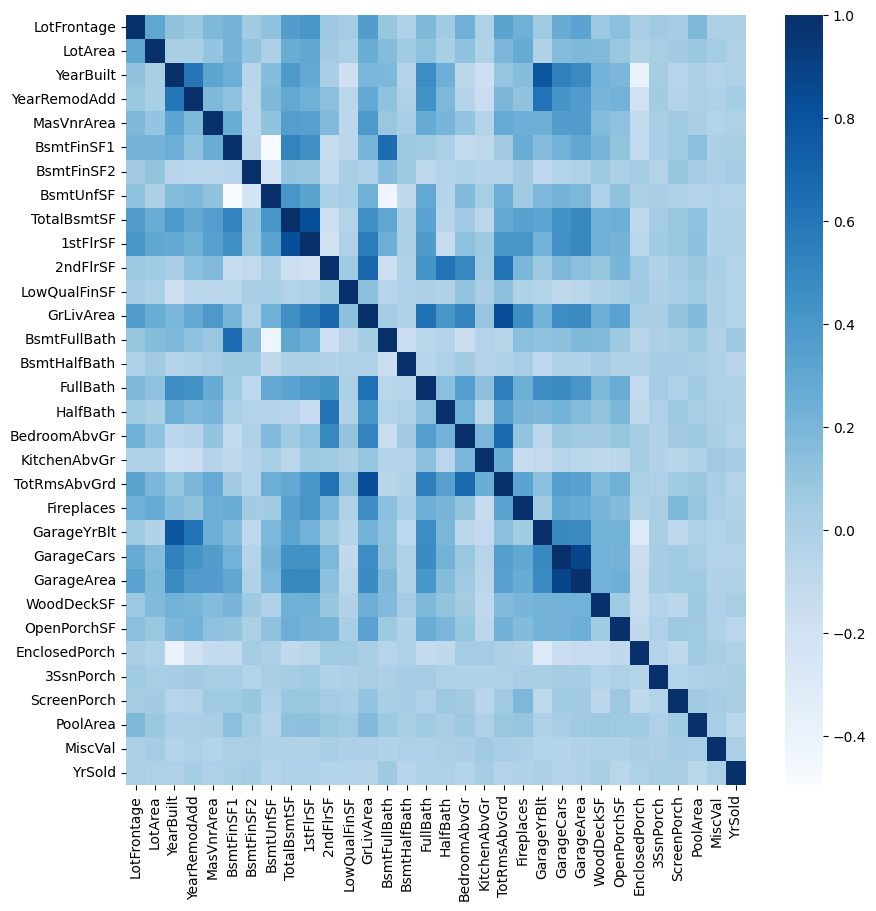

In [14]:
# correlation matrix between numeric variables

numvars = data2.select_dtypes(include=[np.number])
corr2 = numvars.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr2,cmap='Blues')



One hot enconding to deal with categorical variables

In [15]:
alldata = pd.concat([data2, val2], axis=0)
categorical_cols = alldata.select_dtypes(include=[object]).columns
alldata = pd.get_dummies(alldata, columns=categorical_cols)

data2 = alldata[:len(data2)]
val2 = alldata[len(data2):]

print(data2.shape)
print(val2.shape)

(1460, 330)
(1459, 330)


#### Modelling

In [16]:
# train test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data2, y, test_size=0.2, random_state=42)

In [17]:
# test several models in default settings

MLA = [
    #LinearRegression(), linear regression is bugging for some reason
    Lasso(),
    Ridge(),
    ElasticNetCV(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    SVR()
]

In [18]:
print(y.shape)
print(data2.shape)

(1460,)
(1460, 330)


In [19]:
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0) # run model 10x with 60/30 split intentionally leaving out 10%

In [ ]:


# create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters', 'MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD', 'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)


# index through MLA and save performance to table
row_index = 0
for alg in MLA:

    # name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())

    # score with cv
    cv_results = model_selection.cross_validate(alg, data2, y, cv = cv_split, return_train_score = True)
    MLA_compare.loc[row_index, 'MLA RMSE'] = np.sqrt(-model_selection.cross_val_score(alg, data2, y, cv = cv_split, scoring = 'neg_mean_squared_error').mean())
    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3 # statistically captures 99.7% of the subsets (the worst case scenario)
    # "The Empirical Rule states that 99.7% of data observed following a normal distribution lies within 3 standard deviations of the mean."


    # save preds

    alg.fit(data2, y)

    row_index += 1

# print and sort table
    
MLA_compare.sort_values(by = ['MLA RMSE'], ascending = True, inplace = True) # show highest accuracy first
MLA_compare


,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time,MLA RMSE
4,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",0.966677,0.885803,0.02197,0.909277,0.137454
3,RandomForestRegressor,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...",0.979613,0.860593,0.039505,3.639143,0.151940
1,Ridge,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",0.950512,0.836631,0.11947,0.027053,0.163663
5,SVR,"{'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'd...",0.740726,0.727882,0.057926,0.08436,0.212111
2,ElasticNetCV,"{'alphas': None, 'copy_X': True, 'cv': None, '...",0.773799,0.724597,0.21869,0.276018,0.213537
0,Lasso,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",0.775116,0.724597,0.217181,0.049276,0.213592


Tuning Lasso

In [ ]:
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],  # Regularization strength
    'tol': [0.0001, 0.001, 0.01],  # Tolerance for optimization
    'max_iter': [1000, 2000, 3000]  # Maximum number of iterations
}

lasso = Lasso(fit_intercept=True)

grid_search = model_selection.GridSearchCV(lasso, param_grid, cv=cv_split, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(data2, y)

# get best score and best parameters

print(grid_search.best_score_)
print(grid_search.best_params_)


-0.024971779598196107
{'alpha': 0.001, 'max_iter': 1000, 'tol': 0.0001}


In [23]:
bestlasso = Lasso(alpha=0.001, tol=0.0001, max_iter=1000, fit_intercept=True)
bestlasso.fit(X_train, y_train)

# score with RMSE

y_pred = bestlasso.predict(X_test)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
acc = bestlasso.score(X_test, y_test)
print("RMSE: ", rmse)
print("Accuracy: ", acc)

RMSE:  0.14409644055525098
Accuracy:  0.8887322534557676


In [ ]:
# predict with best lasso 

y_val = bestlasso.predict(val2)
print(y_val)

# convert to original scale

y_val = np.expm1(y_val)
#print(y_val)

# create submission

submission = pd.DataFrame({'Id': val_data['Id'], 'SalePrice': y_val})
print(submission.head(10))

submission.to_csv('submission.csv', index=False) # got a RMSE of 0.14662 on kaggle


[11.68471171 11.85919288 12.09676698 ... 11.97298894 11.72892903
 12.33997568]
     Id      SalePrice
0  1461  118741.398680
1  1462  141377.062834
2  1463  179290.271217
3  1464  196996.467354
4  1465  189544.452030
5  1466  172777.723297
6  1467  188538.475700
7  1468  164973.712042
8  1469  191408.106192
9  1470  124893.942203


In [ ]:
# get best lasso coefficients

print(bestlasso.coef_)

[-5.34498312e-04  1.44353902e-06  1.64907595e-03  1.67563827e-03
 -1.65630773e-06  1.61062818e-05  1.90230246e-05  2.69377516e-05
  1.79446400e-05  2.00831080e-04  2.03569053e-04  2.25965873e-04
  2.67737076e-05  4.06419952e-02  0.00000000e+00  2.71770985e-02
  2.08731236e-02  6.07079606e-03 -3.09843803e-02  8.09920588e-03
  3.71470186e-02 -6.05461499e-04  5.47358203e-02  8.38982230e-05
  1.21935904e-04  3.34217760e-05  1.13617912e-04  2.40464436e-04
  3.05890236e-04 -1.63260782e-04 -2.61323505e-06 -4.18504542e-03
  0.00000000e+00  0.00000000e+00 -5.42972701e-02 -0.00000000e+00
  0.00000000e+00  1.91452456e-02 -6.20668282e-02  0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -1.63162769e-02  6.12776659e-03
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  1.09774761e-02  0.00000000e+00  0.00000000e+00
 -4.30974254e-02 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  6.99374881e-03 -0.00000000e+00
 -0.00000000e+00 -3.51778

In [24]:
# feature selection based on lasso coeffs

from sklearn.feature_selection import SelectFromModel

bestlassowithFS = Lasso(alpha=0.001, tol=0.0001, max_iter=1000, fit_intercept=True)

sfm = SelectFromModel(bestlassowithFS, threshold="mean")
xnew = sfm.fit_transform(data2, y)
xnewtest = sfm.transform(val2)
X_trainnew = sfm.transform(X_train)
X_testnew = sfm.transform(X_test)

# selected features

selected_features = data2.columns[sfm.get_support()]
print(selected_features)


Index(['BsmtFullBath', 'FullBath', 'HalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageCars', 'MSSubClass_160.0', 'MSSubClass_20.0',
       'MSSubClass_30.0', 'MSSubClass_60.0', 'MSZoning_C (all)', 'MSZoning_RM',
       'LandContour_Bnk', 'LotConfig_CulDSac', 'Neighborhood_BrkSide',
       'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_MeadowV',
       'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_Somerst',
       'Neighborhood_StoneBr', 'Condition1_Norm', 'BldgType_1Fam',
       'BldgType_Twnhs', 'HouseStyle_2Story', 'OverallQual_3.0',
       'OverallQual_4.0', 'OverallQual_5.0', 'OverallQual_7.0',
       'OverallQual_8.0', 'OverallQual_9.0', 'OverallCond_3.0',
       'OverallCond_4.0', 'OverallCond_5.0', 'OverallCond_7.0',
       'OverallCond_9.0', 'RoofMatl_ClyTile', 'Exterior1st_BrkFace',
       'ExterQual_TA', 'ExterCond_Fa', 'Foundation_PConc', 'BsmtQual_Ex',
       'BsmtCond_Fa', 'BsmtExposure_Gd', 'BsmtExposure_No', 'BsmtFinTyp

In [25]:
# fit best lasso with selected features

bestlassowithFS.fit(X_trainnew, y_train)

# score with RMSE

y_pred = bestlassowithFS.predict(X_testnew)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
acc = bestlassowithFS.score(X_testnew, y_test)
print("RMSE: ", rmse)
print("Accuracy: ", acc)

# got worse results with feature selection

bestlasso.fit(xnew,y)
# predict

y_val = bestlasso.predict(xnewtest)
print(y_val)

# convert to original scale

y_val = np.expm1(y_val)
#print(y_val)

# create submission

submission = pd.DataFrame({'Id': val_data['Id'], 'SalePrice': y_val})
print(submission.head(10))

submission.to_csv('submissionFS.csv', index=False) # got a RMSE of 0.16331 on kaggle (worse, close to what was predicted)

RMSE:  0.1606874720841902
Accuracy:  0.8616348164701534
[11.64435736 11.86241884 12.02689836 ... 11.97429424 11.64534235
 12.37934123]
     Id      SalePrice
0  1461  114045.023474
1  1462  141833.879270
2  1463  167191.038419
3  1464  202118.059722
4  1465  191164.286237
5  1466  170520.159580
6  1467  185191.373696
7  1468  170520.159580
8  1469  195357.368367
9  1470  121227.293612


Tuning GradientBoostingRegressor

In [ ]:
# TAKES VERY LONG TO RUN

param_grid = {
    'n_estimators': [50, 100, 200],  # Number of boosting stages
    'learning_rate': [0.05, 0.1, 0.2],  # Learning rate
    'max_depth': [2, 3, 4, 5],  # Maximum depth of the individual estimators
    'min_samples_split': [2, 3, 4],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 3],  # Minimum number of samples required to be at a leaf node
    'subsample': [0.8, 0.9, 1.0],  # Fraction of samples used for fitting the individual base learners
}

gbr = GradientBoostingRegressor()

grid_search = model_selection.GridSearchCV(gbr, param_grid, cv=cv_split, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(data2, y)

# get best score and best parameters

print(grid_search.best_score_)
print(grid_search.best_params_) 

# predict with best gbr


-0.017503564436788365
{'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 200, 'subsample': 0.9}


In [26]:
# best gbr

bestgbr = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, min_samples_split=2, min_samples_leaf=3, subsample=0.9)
bestgbr.fit(X_train, y_train)

# score with RMSE

y_pred = bestgbr.predict(X_test)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
acc = bestgbr.score(X_test, y_test)
print("RMSE: ", rmse)
print("Accuracy: ", acc)

RMSE:  0.13825790369767865
Accuracy:  0.8975663326184203


In [ ]:
# predict with best gbr

y_valgbr = bestgbr.predict(val2)
print(y_valgbr)

# convert to original scale

y_valgbr = np.expm1(y_valgbr)
print(y_valgbr)

# create submission

submission2 = pd.DataFrame({'Id': val_data['Id'], 'SalePrice': y_valgbr})
print(submission2.head(10))

submission2.to_csv('submission2.csv', index=False) # got a RMSE of 0.14052 on kaggle (improved!)


[11.74129329 11.90504373 12.15661349 ... 12.01278576 11.77485709
 12.31440239]
[125653.74358977 148010.27475732 190347.8054296  ... 164848.09442668
 129942.76936923 222882.03106648]
     Id      SalePrice
0  1461  125653.743590
1  1462  148010.274757
2  1463  190347.805430
3  1464  190799.468832
4  1465  195382.701843
5  1466  179289.463278
6  1467  176734.874173
7  1468  168226.989090
8  1469  179293.995446
9  1470  127058.102606


In [30]:
# feature selection on the best gbr
bestgbrFS = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, min_samples_split=2, min_samples_leaf=3, subsample=0.9)

selectorGBR = feature_selection.RFECV(bestgbrFS, step=1, cv=cv_split, scoring='neg_mean_squared_error')
selectorGBR = selectorGBR.fit(data2, y)

# selected features

selected_featuresGBR = data2.columns[selectorGBR.support_]
print(selected_features)

# fit best gbr with selected features

bestgbrFS.fit(X_train[selected_features], y_train)


Index(['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       ...
       'SaleType_ConLD', 'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New',
       'SaleType_Oth', 'SaleType_WD', 'SaleCondition_Abnorml',
       'SaleCondition_AdjLand', 'SaleCondition_Alloca',
       'SaleCondition_Family'],
      dtype='object', length=207)


GradientBoostingRegressor(min_samples_leaf=3, n_estimators=200, subsample=0.9)

In [42]:
selected_featuresGBR = data2.columns[selector.support_]
print(len(selected_features))

207


In [43]:
# eliminated features

eliminated_features = data2.columns[~selector.support_]
print(eliminated_features)

Index(['MSSubClass_120.0', 'MSSubClass_160.0', 'MSSubClass_85.0',
       'LotShape_IR1', 'LotShape_IR2', 'LandContour_HLS', 'LotConfig_FR3',
       'Neighborhood_BrDale', 'Neighborhood_Gilbert', 'Neighborhood_IDOTRR',
       ...
       'PoolQC_Fa', 'PoolQC_Gd', 'Fence_GdPrv', 'Fence_MnPrv', 'Fence_MnWw',
       'MiscFeature_Gar2', 'MiscFeature_Othr', 'MiscFeature_Shed',
       'SaleCondition_Normal', 'SaleCondition_Partial'],
      dtype='object', length=123)


In [29]:
# score with rmse

y_pred = bestgbrFS.predict(X_test[selected_features])
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
acc = bestgbr.score(X_test[selected_features], y_test)
print("RMSE: ", rmse)
print("Accuracy: ", acc)


RMSE:  0.1379752415439019
Accuracy:  0.8979847466484241


In [ ]:
# predict with best gbr trained with selected features

y_valgbr = bestgbrFS.predict(val2[selected_features])
#print(y_valgbr)

# convert to original scale

y_valgbr = np.expm1(y_valgbr)
print(y_valgbr)

# create submission

submission3 = pd.DataFrame({'Id': val_data['Id'], 'SalePrice': y_valgbr})
print(submission3.head(10))

submission3.to_csv('submission3.csv', index=False) # got 0.13827 




[123421.48157384 150136.9545896  187410.63025114 ... 155406.35775519
 127560.68750343 223994.48386886]
     Id      SalePrice
0  1461  123421.481574
1  1462  150136.954590
2  1463  187410.630251
3  1464  187614.811766
4  1465  191097.581414
5  1466  180708.223889
6  1467  176038.094440
7  1468  169535.379126
8  1469  173296.562333
9  1470  122898.813023


Tune Random Forests

In [ ]:
# hypertune random forests 

param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [2, 3, 4, 5],  # Maximum depth of the tree
    'min_samples_split': [2, 3, 4],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 3],  # Minimum number of samples required to be at a leaf node
    'max_features': [None, 'sqrt', 'log2'],  # Number of features to consider when looking for the best split
}

rfr = RandomForestRegressor()

grid_search = model_selection.GridSearchCV(rfr, param_grid, cv=cv_split, scoring='neg_mean_squared_error', return_train_score=True)

grid_search.fit(data2, y)

# get best score and best parameters

print(grid_search.best_score_)
print(grid_search.best_params_)

-0.02800766862880081
{'max_depth': 5, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 200}


In [22]:
# best rfr

bestrfr = RandomForestRegressor(n_estimators=200, max_depth=5, min_samples_split=4, min_samples_leaf=3, max_features=None)
bestrfr.fit(X_train, y_train)

# score with RMSE

y_pred = bestrfr.predict(X_test)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
acc = bestrfr.score(X_test, y_test)
print("RMSE: ", rmse)
print("Accuracy: ", acc)

# cross val

rmsecv = np.sqrt(-model_selection.cross_val_score(bestrfr, data2, y, cv = cv_split, scoring = 'neg_mean_squared_error').mean())
print("RMSE CV: ", rmsecv)

# results dont appear to be better than gbr

RMSE:  0.17223501492341362
Accuracy:  0.8410334750918725
RMSE CV:  0.16767955391773598


Ridge

In [ ]:
# default ridge

ridge = Ridge()
ridge.fit(X_train, y_train)

# score with RMSE

y_pred = ridge.predict(X_test)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
acc = ridge.score(X_test, y_test)

print("RMSE: ", rmse)
print("Accuracy: ", acc)

RMSE:  0.13383498624070536
Accuracy:  0.904015279713798


In [ ]:
# hypertune ridge

param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],  # Regularization strength
    'tol': [0.000001, 0.00001, 0.0001, 0.001, 0.01],  # Tolerance for optimization
}

ridge = Ridge()

grid_search = model_selection.GridSearchCV(ridge, param_grid, cv=cv_split, scoring='neg_mean_squared_error', return_train_score=True)

grid_search.fit(data2, y)

# get best score and best parameters

print(grid_search.best_score_)
print(grid_search.best_params_)

-0.02432951345049755
{'alpha': 10.0, 'tol': 1e-06}


In [33]:
bestridge = Ridge(alpha=10.0, tol=1e-06)

bestridge.fit(X_train, y_train)

# score with RMSE

y_pred = bestridge.predict(X_test)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
acc = bestridge.score(X_test, y_test)

print("RMSE: ", rmse)
print("Accuracy: ", acc)

# score with cv

rmsecv = np.sqrt(-model_selection.cross_val_score(bestridge, data2, y, cv = cv_split, scoring = 'neg_mean_squared_error').mean())
print("RMSE CV: ", rmsecv)


RMSE:  0.14138867627737545
Accuracy:  0.8928747019100058
RMSE CV:  0.15597920839168775


In [37]:
bestridgeFS = Ridge(alpha=10.0, tol=1e-06)

selectorRidge = feature_selection.RFECV(bestridgeFS, step=1, cv=cv_split, scoring='neg_mean_squared_error')

selectorRidge = selectorRidge.fit(data2, y)

# selected features

selected_featuresRidge = data2.columns[selectorRidge.support_]

# fit best ridge with selected features

bestridgeFS.fit(X_train[selected_featuresRidge], y_train)

# score with RMSE

y_pred = bestridgeFS.predict(X_test[selected_featuresRidge])
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
acc = bestridgeFS.score(X_test[selected_featuresRidge], y_test)

print("RMSE: ", rmse)
print("Accuracy: ", acc)

# score with cv

rmsecv = np.sqrt(-model_selection.cross_val_score(bestridgeFS, data2[selected_featuresRidge], y, cv = cv_split, scoring = 'neg_mean_squared_error').mean())
print("RMSE CV: ", rmsecv)



RMSE:  0.14586492117843408
Accuracy:  0.8859843389113184
RMSE CV:  0.14059210054942772


The RMSE CV shows improvement witg FS

SVR

In [ ]:
# default svr

svr = SVR()
svr.fit(X_train, y_train)

# score with RMSE

y_pred = svr.predict(X_test)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
acc = svr.score(X_test, y_test)

print("RMSE: ", rmse)
print("Accuracy: ", acc)

# score with cv

rmsecv = np.sqrt(-model_selection.cross_val_score(svr, data2, y, cv = cv_split, scoring = 'neg_mean_squared_error').mean())

print("RMSE CV: ", rmsecv)

RMSE:  0.21415071083275472
Accuracy:  0.7542453030396209
RMSE CV:  0.2121109142597209


In [ ]:
# hypertune svr

param_grid = {
    'C': [0.1, 1.0, 10.0],  # Regularization parameter
    'epsilon': [0.1, 0.2, 0.3],  # Epsilon in the epsilon-SVR model
}

svr = SVR()

grid_search = model_selection.GridSearchCV(svr, param_grid, cv=3, scoring='neg_mean_squared_error', return_train_score=True)

grid_search.fit(data2, y)

# get best score and best parameters

print(grid_search.best_score_)
print(grid_search.best_params_)

Stacked Ensemble (bestlasso+bestgbr+bestridge+bestrf) using StackingRegressor

In [25]:
# stacking classifier with best models

estimators = [
    ('gbr', bestgbr),
    ('ridge', bestridge),
    ('lasso', bestlasso),
    ('rfr', bestrfr)
]

from sklearn.ensemble import StackingRegressor

# with random forests as final estimator

stacking = StackingRegressor(estimators=estimators, final_estimator=RandomForestRegressor())

stacking.fit(X_train, y_train)

# score with RMSE

y_pred = stacking.predict(X_test)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
acc = stacking.score(X_test, y_test)

print("RMSE: ", rmse)
print("Accuracy: ", acc)

# score with cv

#rmsecv = np.sqrt(-model_selection.cross_val_score(stacking, data2, y, cv = cv_split, scoring = 'neg_mean_squared_error').mean())

#print("RMSE CV: ", rmsecv)



RMSE:  0.1541382883317153
Accuracy:  0.8726837464960115


In [30]:
# with gradient boosting as final estimator

stackingGBR = StackingRegressor(estimators=estimators, final_estimator=GradientBoostingRegressor())

stackingGBR.fit(X_train, y_train)

# score with RMSE

y_pred = stackingGBR.predict(X_test)

rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
acc = stackingGBR.score(X_test, y_test)

print("RMSE: ", rmse)
print("Accuracy: ", acc)

# score with cv

rmsecv = np.sqrt(-model_selection.cross_val_score(stackingGBR, data2, y, cv = cv_split, scoring = 'neg_mean_squared_error').mean())

print("RMSE CV: ", rmsecv)

RMSE:  0.13863669535039136
Accuracy:  0.897004279099527
RMSE CV:  0.13392570823011435


In [29]:
# with ridge as final estimator

stackingRidge = StackingRegressor(estimators=estimators, final_estimator=Ridge())

stackingRidge.fit(X_train, y_train)

# score with RMSE

y_pred = stackingRidge.predict(X_test)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
acc = stackingRidge.score(X_test, y_test)

print("RMSE: ", rmse)
print("Accuracy: ", acc)

# score with cv

rmsecv = np.sqrt(-model_selection.cross_val_score(stackingRidge, data2, y, cv = cv_split, scoring = 'neg_mean_squared_error').mean())

print("RMSE CV: ", rmsecv)

RMSE:  0.13498552584211485
Accuracy:  0.9023578818983693
RMSE CV:  0.13936567244472145


In [31]:
# with linear regression as final estimator

stackingLR = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())

stackingLR.fit(X_train, y_train)

# score with RMSE

y_pred = stackingLR.predict(X_test)

rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
acc = stackingLR.score(X_test, y_test)

print("RMSE: ", rmse)
print("Accuracy: ", acc)

# score with cv 

rmsecv = np.sqrt(-model_selection.cross_val_score(stackingLR, data2, y, cv = cv_split, scoring = 'neg_mean_squared_error').mean())

print("RMSE CV: ", rmsecv)

RMSE:  0.13550704066301142
Accuracy:  0.9016019463372248
RMSE CV:  0.1391714461915308


GBR appears to be the best final estimator

In [32]:
# train with whole data

stackingGBR.fit(data2, y)

# predict

y_val = stackingGBR.predict(val2)

# convert to original scale

y_val = np.expm1(y_val)

# create submission

submission4 = pd.DataFrame({'Id': val_data['Id'], 'SalePrice': y_val})

submission4.to_csv('submission4.csv', index=False) # got 0.1419, did not improve

Alternative stack with only the two best models

In [34]:
# predict with best gbr

bestgbr.fit(data2, y)

# predict

y_valGBR = bestgbr.predict(val2)

# convert to original scale

y_valGBR = np.expm1(y_valGBR)

# predict with best ridge

bestridge.fit(data2, y)

# predict

y_valRidge = bestridge.predict(val2)

# convert to original scale

y_valRidge = np.expm1(y_valRidge)

# stack

yval = y_valGBR*0.7 + y_valRidge*0.3

# create submission

submission5 = pd.DataFrame({'Id': val_data['Id'], 'SalePrice': yval})

submission5.to_csv('submission5.csv', index=False) # got 0.13418

In [35]:
# predict with bestgbrFS

bestgbrFS.fit(data2[selected_features], y)

yfs = bestgbrFS.predict(val2[selected_features])

yfs = np.expm1(yfs)

# stack

yval = yfs*0.7 + y_valRidge*0.3

# create submission

submission6 = pd.DataFrame({'Id': val_data['Id'], 'SalePrice': yval})

submission6.to_csv('submission6.csv', index=False) # got 0.13356, best so far

In [38]:
bestridgeFS.fit(data2[selected_featuresRidge], y)

yfsR = bestridgeFS.predict(val2[selected_featuresRidge])
yfsR = np.expm1(yfsR)

# stack

yval = yfs*0.7 + yfsR*0.3

# create submission

submission7 = pd.DataFrame({'Id': val_data['Id'], 'SalePrice': yval})

submission7.to_csv('submission7.csv', index=False) # got 0.1359, no improvement
